# Анализ оттока клиентов банка

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st 
from scipy.stats import f_oneway, levene

## Загрузка и описание данных

Загрузим данные и посмотрим первые строки датасета.

In [2]:
df_initial=pd.read_csv(r'D:\Analysis\repository_prakticum\some_bank.csv', sep=';')
df_initial.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Город_2,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Город_2,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Город_2,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Обл_центр,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Обл_центр,М,34.0,5,174.00,1,1,0,67353.16,1


Приведем названия всех столбцов к нижнему регистру и выведем общую информацию о содержащихся данных.

In [3]:
df_initial.columns = df_initial.columns.str.lower()
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


<i>Комментарий.</i>
- Таблица содержит 12 столбцов и 10000 строк.
- В столбцах city и gender ячейки содержат данные типа object, в остальных столбцах содержится числовая информация - int, float.
- В столбцах age и score приведены целочисленные данные, что не соответсвует их типу (float). В age это, вероятно, связано с пропусками в данных.
- В данных присутсвуют пропуски в столбцах age и balance. Далее исследуем их и примем решение об их обработке.

## Предобработка данных

В дальнейшем будем работать с копией исходного датасета.

In [4]:
df=df_initial.copy()
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Город_2,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Город_2,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Город_2,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Обл_центр,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Обл_центр,М,34.0,5,174.00,1,1,0,67353.16,1


Сохраним исходное количество строк в переменной initial_length для оценки количества удаленных данных (при наличии таковых).

In [5]:
initial_length=len(df)
print(f'Количество строк в исходном датафрейме - {initial_length}.')

Количество строк в исходном датафрейме - 10000.


### Пропуски

Проверим датафрейм на наличие пропусков.

In [6]:
df.isna().sum()

userid              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

*Комментарий.*
- В колонке age 26 пропуска, что составляет менее 1% от всех данных, их удаление не приведет к искажению данных.
- В колонке balance 2295 пропусков, что составляет более 20% от всех данных. Удаление или заполнение пропусков может привести к сильному искажению результатов анализа.

Определим типы пропусков. И примем решение об их обработке:
- Создадим новый столбец 'no_data', значения в котором принимают 1, если пропуски в данных есть, и 0, если пропусков нет.
- Оценим медианное значение для каждого параметра (колонки) среди данных с пропусками и без них, категориальные переменные не будем учитывать.
- Определим тип пропусков и подход к их обработке.

In [7]:
#Создадим новый столбец 'no_data'.
df['no_data'] = df.isnull().apply(lambda row: 1 if any(row) else 0, axis=1)
df.head(2)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,no_data
0,183012,850.0,Город_2,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0
1,146556,861.0,Город_2,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0


In [8]:
#Исключим категориальные переменные и userid,
#объединим оставшиеся значения по столбцу 'no_data',
#посчитаем медианнное значение.
df.drop(columns=['userid', 'city', 'gender']).groupby('no_data').median()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
no_data,,,,,,,,,
0,840.0,40.0,4,524295.330,2,1,1,106250.18,0
1,902.0,40.0,0,417361.115,1,1,1,173879.98,0


*Комментарий.* Из таблицы видно, что для наблюдений без пропусков (no_data = 0) и с пропусками (no_data = 1) медианы некоторых признаков различаются:
- Медиана age не зависит от пропусков => их удаление не приведет к искажению данных, тип пропусков MCAR. 
- Медиана balance выше для наблюдений без пропусков => может говорить о пропусках типа MAR.
- Медиана est_salary выше для наблюдений с пропусками => может быть признаком того, что пропущенные в balance данные зависят от значений этого столбца и относятся к типу MNAR.


Пропуски в age удалим.
<br>Пропуски в balance не являются полностью случайными (MCAR), а могут быть связаны с определёнными характеристиками наблюдений (MAR или MNAR). К настоящему времени по результатам многчисленных исследований известно, что уровень дохода (est_salary в нашем случае) сильно коррелирует с возрастом. Поскольку мы видим зависимость balance от est_salary, заполним пропуски в balance следующим образом:
- Разделим всех клиентов на возрастные группы по квартилям колонки age (0-0.25, 0.25-0.5, 0.5-0.75, 0.75-max_'age').
- Заполним пропуски в balance по возрастным категориям средним медианным значением balance для этой категории.

In [9]:
#Удалим пропуски в age.
df=df.dropna(subset=['age'])

print(f'Количество пропусков в колонке age после обработки - {df["age"].isna().sum()}.')

Количество пропусков в колонке age после обработки - 0.


In [10]:
#Вычислим квартили для столбца 'age'.
quartiles = df['age'].quantile([0.25, 0.50, 0.75])

#Создадим новую колонку с возрастными группами на основе вычисленных квартилей.
df['age_group_quantiles'] = pd.cut(df['age'], 
                              bins=[0, quartiles[0.25], quartiles[0.50], quartiles[0.75], df['age'].max()]) 
                              
#Рассчитаем медианные значения 'balance' для каждой группы.
median_values = df.groupby('age_group_quantiles')['balance'].median()

#Заполним пропуски в 'balance' медианными значениями по группам.
df['balance'] = (
    df['balance']
    .fillna(df['age_group_quantiles']
            .map(median_values))
    )

print(f'Количество пропусков в balance после заполнения их \
медианным значением по возрастным группам - {df["balance"].isna().sum()}.')

Количество пропусков в balance после заполнения их медианным значением по возрастным группам - 0.


In [11]:
print(f'Количество удаленных данных - {(1-len(df)/initial_length):.2%}.')

Количество удаленных данных - 0.26%.


*Комментарий.* Пропуски обработаны:
- в колонке age удалены 26 пропусков;
- в колонке balance пропуски заполнены медианным значением по возрастным группам, выделенным на основе квартилей (25%, 50% и 75%). *При последующем анализе значений, приведенных в balance, необходимо учитывать, что более 20% данных заполнены вручную*;
- удалено <1% исходных данных.

### Дубликаты

Проверим данные на наличие явных и неявных дубликатов. При обнаружении таковых примем решение об их обработке.

In [12]:
print(f'Количество явных дубликатов в датасете равно {df.duplicated().sum()}.')

Количество явных дубликатов в датасете равно 0.


Оценим количество дублирующих значений одновременно по колонкам userid и city.

In [13]:
print(f'Количество дубликатов по колонкам userid и city равно {df[["userid", "city"]].duplicated().sum()}.')

Количество дубликатов по колонкам userid и city равно 0.


Проверим userid (уникальный идентификатор пользователя) на наличие дубликатов.

In [14]:
print(f'Количество дубликатов идентификатора пользователя (userid) равно {df["userid"].duplicated().sum()}.')

Количество дубликатов идентификатора пользователя (userid) равно 50.


Оценим, как дубликаты в userid распределены по городам:
- посчитаем количество клиентов, объединив их по городам (by_city),
- посчитаем количество дубликактов по userid среди всех данных по городам (double_by_city),
- посчиатем % дубликатов userid для каждого города (result['percent_duplicated']).

In [15]:
by_city = df.groupby('city')['userid'].count()
double_by_city = df[df['userid'].duplicated(keep=False)].groupby('city')['userid'].count()
result = double_by_city.to_frame('duplicates').join(by_city)
result['percent_duplicates'] = (result['duplicates'] / result['userid']) * 100

result

,duplicates,userid,percent_duplicates
city,,,
Город_2,50,2683,1.863586
Обл_центр,50,5875,0.851064


*Комментарий.* Все обнаруженные по userid дубликаты приходятся на два города: Город_2 и Обл_центр. В Городе 2 их доля ожидаемо выше (т.к. население меньше) и составляет 1,9%, для областного центра - 0,9%.

**Похоже, существует проблема в части обмена информацией о клиентах между Городом 2 и областным центром.**

Посмотим есть ли среди клиентов совпадения по userid, gender - с высокой вероятностью это одни и те же клиенты. Если также присуствует совпадение по age - идентифицируем их как одного клиента.
<br>Выведем строки датасета с дубликатами, отсортировав их сначала по userid, затем по age.

In [16]:
df[df[['userid', 'gender']].duplicated(keep=False)].sort_values(by=['userid', 'age'])

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,no_data,age_group_quantiles
7694,116540,887.0,Обл_центр,Ж,38.0,0,560746.410,1,0,1,119247.61,0,1,"(33.0, 40.0]"
1893,116540,883.0,Город_2,Ж,55.0,1,631478.520,3,0,1,175920.48,1,0,"(51.0, 86.0]"
4866,117943,855.0,Город_2,Ж,32.0,6,366391.025,4,1,1,107792.71,1,0,"(0.0, 33.0]"
7542,117943,880.0,Обл_центр,Ж,40.0,0,560746.410,1,1,0,137718.93,0,1,"(33.0, 40.0]"
9775,124450,758.0,Город_2,Ж,36.0,0,560746.410,2,0,1,79963.59,0,0,"(33.0, 40.0]"
8164,124450,859.0,Обл_центр,Ж,38.0,6,560746.410,1,1,1,95144.63,1,0,"(33.0, 40.0]"
4850,126368,909.0,Обл_центр,Ж,30.0,4,366391.025,2,0,1,140675.66,1,0,"(0.0, 33.0]"
5420,126368,832.0,Город_2,Ж,33.0,0,366391.025,1,0,0,118465.34,0,1,"(0.0, 33.0]"
3988,129785,904.0,Город_2,М,33.0,5,366391.025,3,0,1,188856.75,1,0,"(0.0, 33.0]"
9504,129785,949.0,Обл_центр,М,43.0,0,562550.745,1,1,1,166845.37,0,1,"(40.0, 51.0]"


*Комментарий.*
- Возможна ситуация, когда пользователи, например, 155765 и 227795, судя по city и churn, остались клиентами банка, но сменили офис территорияльно. Возможно сменили город жительства. Таких клиентов нельзя считать отточными, напротив, они проявляют лояльность к банку в целом.
- Однако среди других пользователей встречается нелогичная ситуация: например, userid=210662 в Городе 2 в возрасте 37 лет является клиентом банка, а в областном центре в возрасте 54 лет попал в отток. Если предположить, что клиент переехал, то в Городе 2 он так же должен был попасть в отток.
- Оставшиеся данные, не имеющие совпадений по gender, сложно интерпретировать. В этом случае возможны ситуации, что разным людям был назначен одинаковый userid, или же присутсвует ошибка в анкетных данных в графе gender. Это также подтверждает, что **между офисами в областном центре и Городе 2 плохо настроен обмен информацией.**

Поскольку в первую очередь стоит задача проанализировать отточных клиентов, для дальнейшей работы с данными удалим все дубликаты в столбце userid, для которых churn == 0, т.е. тех, кто является клиентом банка:
- найдем все дубликаты по userid и запишем их в duplicates_userid,
- оставим только те строки, которые входят в duplicates_userid и где churn == 1,
- добавим к отобраным строкам из дубликатов уникальные строки (не являются дубликатами), результат запишем в clients, с которой продолжим работу.

In [17]:
#Создаем маску для поиска дубликатов по userid.
duplicates_userid = df.duplicated(subset=['userid'], keep=False)

#Фильтруем дубликаты и оставляем только те, где churn == 1.
filtered_df = df[duplicates_userid & (df['churn'] == 1)]

#Добавляем уникальные строки, которые не являются дубликатами.
clients = (pd
           .concat([df[~duplicates_userid], filtered_df])     #Добавляем уникальные строки, которые не являются дубликатами.
           .drop(columns=['age_group_quantiles', 'no_data'])  #Удаляем "временные" столбцы, которые не нужны для дальнейшего анализа.
           .reset_index(drop=True))

print(f'Количество дубликатов по userid - {clients["userid"].duplicated().sum()}.')

Количество дубликатов по userid - 0.


In [18]:
print(f'Общее количество удаленных строк - {initial_length - len(clients)}. \
Доля удаленных строк от исходного набора данных - {(1-len(clients)/initial_length):.2%}).')

Общее количество удаленных строк - 76. Доля удаленных строк от исходного набора данных - 0.76%).


*Комментарий.* 
<br> Удаление дубликатов привело к потере менее 1% всех данных.

**Важное наблюдение.**
<br> ***Cуществует проблема в части обмена информацией о клиентах между Городом 2 и областным центром.***

### Типы данных

Посмотрим соответствие типов данных приведенным значениям в датасетe clients, с которым будем работать в дальнейшем.

In [19]:
clients.dtypes

userid              int64
score             float64
city               object
gender             object
age               float64
equity              int64
balance          category
products            int64
credit_card         int64
last_activity       int64
est_salary        float64
churn               int64
dtype: object

*Комментарий.*
- В столбцах score и age тип данных - float, хотя приведены целочисленные значения. Сменим на тип int.
- В столбце balance после заполнения пропусков тип данных изменился на category. Вернем тип float.

In [20]:
clients['score']=clients['score'].astype('int')
clients['age']=clients['age'].astype('int')
clients['balance']=clients['balance'].astype('float')

clients[['score', 'age', 'balance']].dtypes

score        int32
age          int32
balance    float64
dtype: object

*Комментарий.* Типы данных приведены в соответствие с представленными значениями в столбцах score, age, balance.

### Кодирование данных

Датасет clients содержит как числовые, так и категориальные переменные. ***Для исследования корреляции*** данных всех представленных колонок между собой выделим их в отдельный датафрейм ***clients_coded*** и закодируем категориальные переменные: city (3 значения), gender (2 значения). Предварительно для сохранения исходных данных сделаем копию исходных столбцов city и gender.

In [21]:
clients_coded = clients.copy()
clients_coded['clients_city'] = clients_coded['city']
clients_coded['clients_gender'] = clients_coded['gender']

clients_coded = pd.get_dummies(
    clients_coded,
    columns=['city', 'gender'],
    prefix={'city': 'city', 'gender': 'gender'}
)

clients_coded.iloc[:, -7:].head()

,clients_city,clients_gender,city_Город_1,city_Город_2,city_Обл_центр,gender_Ж,gender_М
0,Город_2,Ж,0,1,0,1,0
1,Город_2,Ж,0,1,0,1,0
2,Город_2,Ж,0,1,0,1,0
3,Обл_центр,Ж,0,0,1,1,0
4,Обл_центр,М,0,0,1,0,1


*Комментарий.* Категорильные данные закодированы.

### Вывод

Исходные данные готовы к дальнейшему анализу:
- Пропуски обработаны в зависимости от их типа: в колонке age - удалены, в колонке balance - заполнены средним медианным значением возрастной группы (предварительно клиенты разделены на группы по квартилям: до 0,25; 0,25-0,5; 0,5-0,75; 0,75-макс.возраст). *В дальнейшем анализе необходимо учитывать, что 20% данных в balance заполнены вручную.*
- Обработаны неявные дубликаты по совпадениям в колонке userid: удалены строки, в которых клиент не является отточным (churn=0). **Появление дубликатов по userid, вероятнее всего, связано с проблемой обмена информацией о клиентах между Городом 2 и областным центром.**
- Типы данных приведены в соответствие с представленными значениями параметров.
- Категориальные переменные закодированы и готовы для корреляционного анализа.
- Удалено менее 1% всех данных.

## EDA

### Распределение признаков

Представленные признаки можно разделить на категории:
- непрерывные: age, score, est_salary из clients_coded; balance из df_initial (до заполнения пропусков, т.к. их количество составляет более 20%, что не позволит оценить реальное распределение по обработанным данным);
- дискретные: equity, products из clients_coded;
- категориальные: credit_card, last_activity, clients_city, clients_gender из clients_coded.

Исследуем распределение признаков с учетом их категорий.

#### Непрерывные признаки

Изучим, как распределены значения непрервных признаков: построим для каждого violinplot. Поскольку порядок значений отличается для каждой колонки, построим их на отдельных графиках, задейсвтуем цикл.

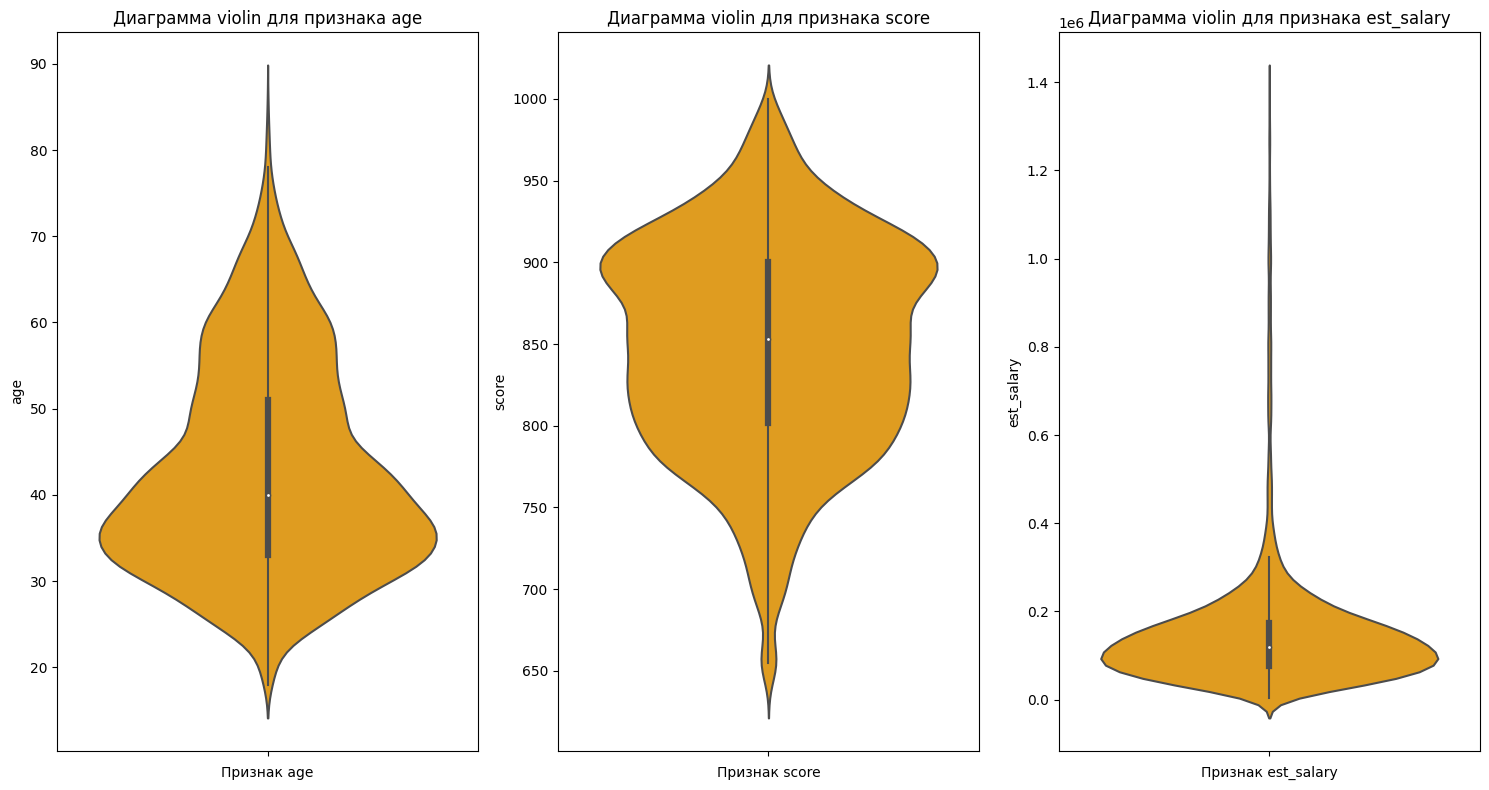

In [22]:
continuous_col = ['age', 'score', 'est_salary']

#Создадим фигуру с 1 строкой и 3 колонками и зададим размер фигуры.
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

#Переберем признаки и построим boxplot на каждом подграфике.
for i, col in enumerate(continuous_col):
    sns.violinplot(data=clients, 
                   y=col, 
                   ax=axes[i],
                   color='orange')
    axes[i].set_title('Диаграмма violin для признака {}'.format(col))
    axes[i].set_xlabel('Признак {}'.format(col))

plt.tight_layout()
plt.show()

*Комментарий.*
1. Признак age (возраст):
   - Все данные находятся в разумных пределах (от 0 до 90).
   - Большинство значений сосредоточено в нижней части диапазона.
   - Медиана находится примерно на уровне 40.
   - Присутствует небольшое количество выбросов, не требующих внимания.<br>
<br>
2. Признак score (баллы кредитного скоринга):
   - Данные распрелены равномерно вокруг медианы.
   - Медиана находится на уровне 850.
   - Большее количество клиентов имеют показатели порядка 900.
   - Присутствует небольшое количество выбросов, не требующих внимания.<br>
<br>
3. Признак est_salary (оценочный доход):
   - Имеет большой диапазон значений от 0 до 1,4 млн.
   - Медиана находится примерно на уровне 0,1 млн.
   - *Присутствует большое количество выбросов. Судя по графику, наибольшое количество клиентов имеет доход до 0,6 млн. Доход выше - лишь единицы. Оценим их количество, предварительно выделив соответствующие iserid в wealthy_clients, и при возможности исключим для дальнейшего анализа данных.*

In [23]:
wealthy_clients = clients.query('est_salary > 0.6*10**6')['userid']

print(f'Количество состоятельных клиентов - {len(wealthy_clients)}.\
\nПроцент состоятельных клиентов - {(len(wealthy_clients)/len(clients)):.2%}.')

Количество состоятельных клиентов - 225.
Процент состоятельных клиентов - 2.27%.


*Комментарий.* Количество состоятельных клиентов (225) более чем в 2 раза меньше, чем требуемое минимальное количество клиентов (500) в сегменте. Их доля невысока (2,27%), не будем учитывать их в дальнейшем анализе этого параметра, оставим только "обычных" клиентов в common_clients.

In [24]:
common_clients = clients.query('est_salary <= 0.6*10**6')
common_clients.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850,Город_2,Ж,25,1,366391.025,2,0,1,75719.14,1
1,146556,861,Город_2,Ж,37,5,560746.410,3,1,0,86621.77,0
2,120722,892,Город_2,Ж,30,0,366391.025,1,1,1,107683.34,0
3,225363,866,Обл_центр,Ж,51,5,562550.745,2,0,1,174423.53,1
4,157978,730,Обл_центр,М,34,5,560746.410,1,1,0,67353.16,1


Для анализа распределения клиентов по balance используем исходный датафрейм df_initial, т.к. пропуски (более 20% данных) заполнили одним (медианным) значением. Это позволит распределить клиентов по группам, но не покажет реальную картину распределения данного параметра.

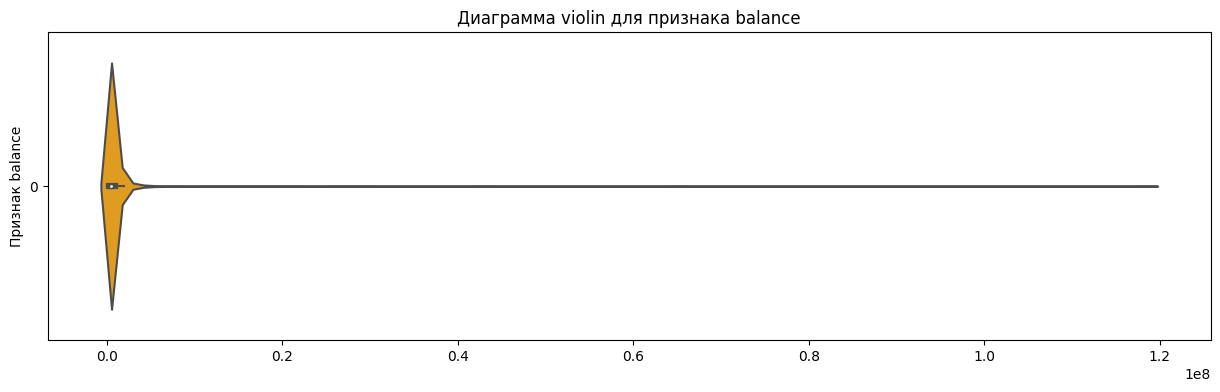

In [25]:
plt.figure(figsize=(15,4))
sns.violinplot(data=df_initial['balance'], 
               orient='h', 
               color='orange')

plt.title('Диаграмма violin для признака balance')
plt.ylabel('Признак balance');

*Комментарий.* Для колонки balance в исходном датафрейме характерны очень большие выбросы. Отсечем их и посмотрим распределение еще раз.

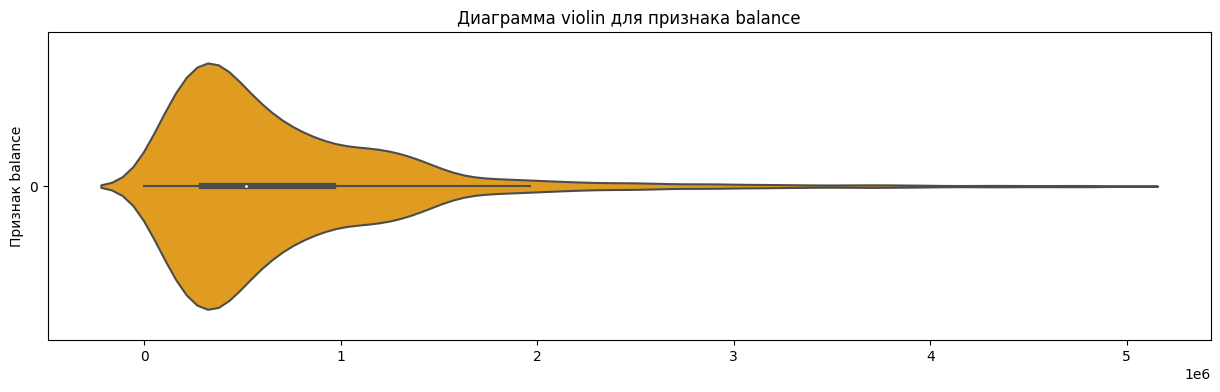

In [26]:
plt.figure(figsize=(15,4))
sns.violinplot(data=df_initial.query('balance <= 0.5*10**7')['balance'], 
               orient='h', 
               color='orange')

plt.title('Диаграмма violin для признака balance')
plt.ylabel('Признак balance');

*Комментарий.* balance (баланс на счете):
- Имеет большой диапазон значений примерно от 0 до 120 млн.
- Медиана находится примерно на уровне 0,5 млн.
- Присутствуют очень большие выбросы. *Судя по графику, небольшое количество клиентов имеет на счету свыше 3 млн. Определим их количество, выделив соответсвующие userid в переменную big_balance без учета удаленных на предыдущих этапах данных, и возможность ограничения данного признака 3 млн. при оценке распределения в разрезе оттока.*

In [27]:
big_balance = df_initial.query('balance > 3*10**6')['userid']

print(f'Количество состоятельных клиентов по balance - {len(big_balance)}.\
\nПроцент состоятельных клиентов по balance\
(по отношению к предобработанным данным) - {(len(big_balance)/len(clients)):.2%}.')

Количество состоятельных клиентов по balance - 201.
Процент состоятельных клиентов по balance(по отношению к предобработанным данным) - 2.03%.


*Комментарий.* Количество состоятельных клиентов по balance (201) более чем в 2 раза меньше, чем требуемое минимальное количество клиентов (500) в сегменте. Их доля невысока (2,03%), не будем учитывать их в дальнейшем анализе этого показателя, оставим только "обычных" клиентов в common_balance_clients и удалим пропуски.

In [28]:
common_balance_clients = df_initial.query('balance <= 3*10**6').dropna()
common_balance_clients.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Город_2,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Город_2,Ж,37.0,5,850594.33,3,1,0,86621.77,0
3,225363,866.0,Обл_центр,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Обл_центр,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Город_2,М,56.0,4,863687.24,3,1,0,156619.80,0


#### Дискретные/категориальные признаки

Передадим переменной discrete_col_names список колонок с дискретными/категориальными значениями.

In [29]:
discrete_col_names = ['equity', 
                      'products', 
                      'credit_card', 
                      'last_activity', 
                      'gender', 
                      'city',
                      'churn']

Построим столбчатую диаграмму (bar) для каждого столбца, используем цикл.

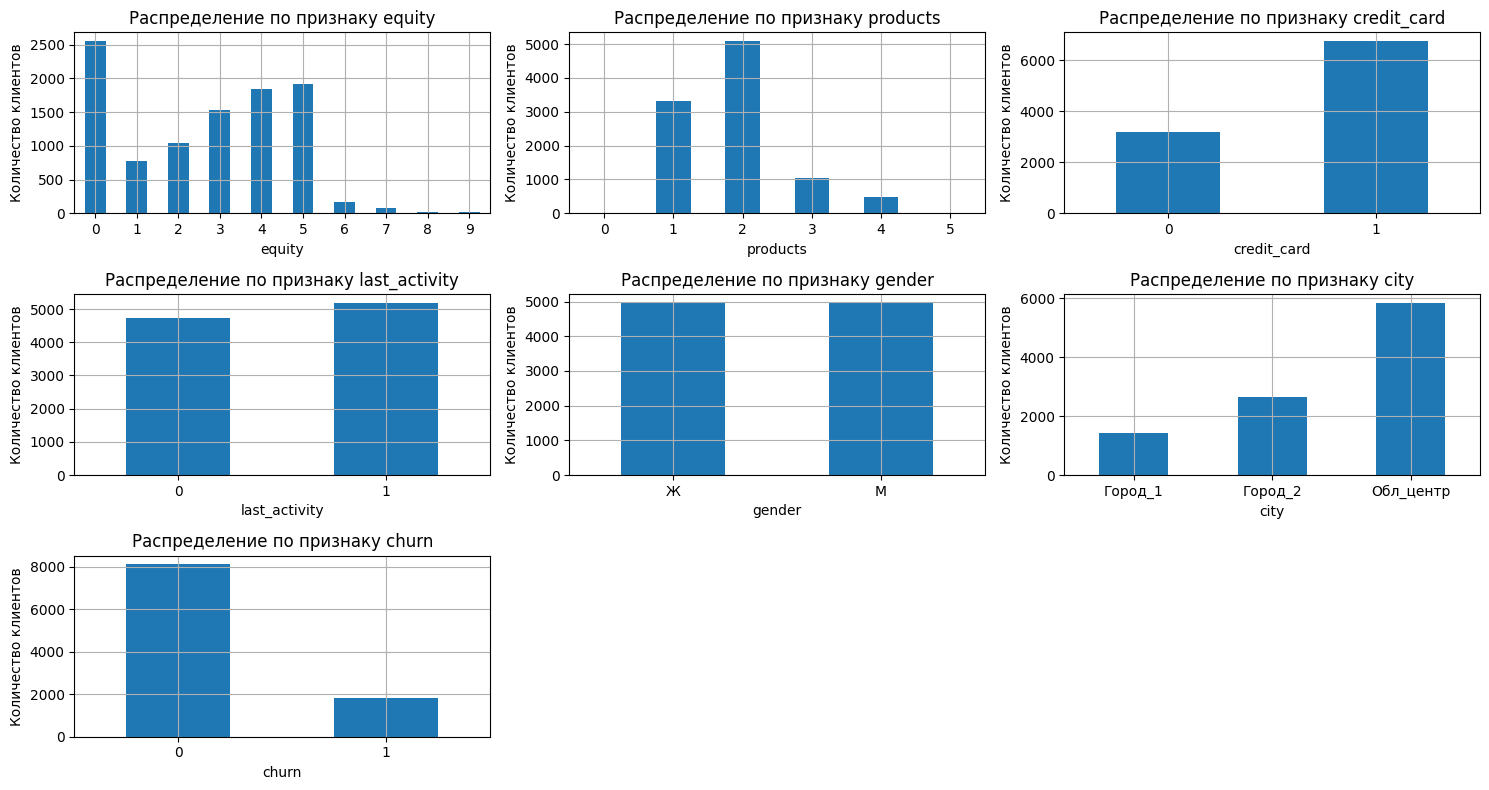

In [30]:
#Создадим сетку графиков 3x3.
fig, axes = plt.subplots(3, 3, figsize=(15, 8))

#Переберем столбцы.
for i, col in enumerate(discrete_col_names):
    #Определим позицию на сетке.
    row = i // 3
    col_pos = i % 3
    
    #Получим текущие оси.
    ax = axes[row, col_pos]
    
    #Сгруппируем данные и построим график.
    (clients
     .groupby(col)
     .size()  #Подсчитаем количество записей.
     .plot(kind='bar', ax=ax, rot=0)
    )
    
    #Оформим графики.
    ax.set_title(f'Распределение по признаку {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Количество клиентов')
    ax.grid(True)

#Удалим пустые оси.
if len(discrete_col_names) < 9:
    for j in range(len(discrete_col_names), 9):
        fig.delaxes(axes.flatten()[j])    
    
plt.tight_layout()
plt.show()

*Комменатрий.*
1. Признак equity (количество баллов собственности):
   - Все данные находятся в разумных пределах (от 0 до 9).
   - Преобладает группа клиентов, у которых отсуствует какая-либо собственность.<br>
<br>
2. Признак products (используемые продукты банка):
   - Данные находятся в разумных пределах (от 1 до 5). *По всей видимости присустсвуют в датасете клиенты, которые не пользуются ни одним продуктом банка. Мы не можем рассматривать их как клиентов, поэтому удалим.*
   - Как правило, клиенты пользуются 1-2 продуктами.<br>
<br>
3. Признак credit_card (наличие кредитной карты):
   - Признак принимает значения 0 или 1.
   - Большинство клиентов имеют кредитную карту.<br>
<br>
4. Признак last_activity (активность в последние 60 дней):
   - Признак принимает значения 0 или 1.
   - Клиенты представлены примерно в равном соотношении, с небольшим перевесом категории, совершавшей действия в последние 60 дней.<br>
<br>   
5. Признак clients_gender (пол):
   - Признак принимает значения 0 или 1.
   - Мужчины и женщины представлены примерно в равном соотношении.<br>
<br>   
6. Признак clients_city (наличие кредитной карты):
   - Представлены клиенты из Ярославя, Рыбинска и Ростова.
   - Клиентов из Ярославля значительно больше, чем из других городов. Меньше всего клиентов в Ростове.<br>
<br>   
7. Признак churn (попал ли клиент в отток - совершал ли действия за последние 90 дней):
   - Признак принимает значения 0 или 1.
   - В данные преобладают клиенты, сохранившие этот статус. Отточных клиентов примерно в 4 раза меньше. *При анализе распределения признаков в разрезе оттока потребуется учесть это и рассматривать нормированные данные.*

In [31]:
#Удалим строки с клиентами, которые не пользуются продуктами банка.
clients = clients.query('products > 0')
#То же самое повторим с датасетом с закодированными данными.
clients_coded = clients_coded.query('products > 0')

print(f'Общий процент удаленных строк - {((initial_length-len(clients))/initial_length):.2%}.')

Общий процент удаленных строк - 0.77%.


#### Вывод

По распределению признаков:
- Были определены характерные значения и интервалы значений.<br>

- Отсеяны несостоятельные данные: 
    1. удалены строки с клиентами, которые не пользуются продуктами банка (products = 0); 
    2. отсеяны клиенты, попавшие в выбросы по признакам 'est_salary' (2,27% данных отфильтровано - common_clients на основе clients), 'balance' (2,03% данных отфильтровано - common_balance_clients на основе df_initial, чтобы исключить влияние большого количества заполненных пропусков).<br>
<br>
- Установлена большая разница в количестве данных для параметра оттока churn. Для корректной оценки клиентов в каждой группе (отточные/лояльные) используем нормировку.

### Распределение признаков в разрезе оттока

Цель анализа распределения признаков в разрезе оттока в зависимости от типа данных:
- непрервные признаки: анализируем, чтобы найти интервалы признака, на которых отток выше, чем лояльность;
- категориальные/дискретные признаки: анализируем, чтобы понять, какое из значений категориального признака более или менее склонно к оттоку.

#### Непрервные признаки

Определим функцию continuous_parameter, которой будем передавать значения непрерывного признака, а на выходе будем получать график распределения признака в зависимости от параметра churn. По результатам определим интервалы значений признака, на которых отток выше, чем лояльность.

In [32]:
def continuous_parameter(data, parameter, bins_value):
    plt.figure(figsize=(15,4))
    sns.histplot(data=data,
                x=parameter,
                hue='churn',
                bins=bins_value,
                stat='density',
                common_norm=False,
                edgecolor='black',
                legend=False)
    plt.legend(title='Категория лояльности клиентов', labels=['Отточные клиенты', 'Лояльные клиенты'])
    plt.title('Распределение параметра {} в зависимости от оттока'.format(parameter))
    plt.xlabel('Параметр {}'.format(parameter));

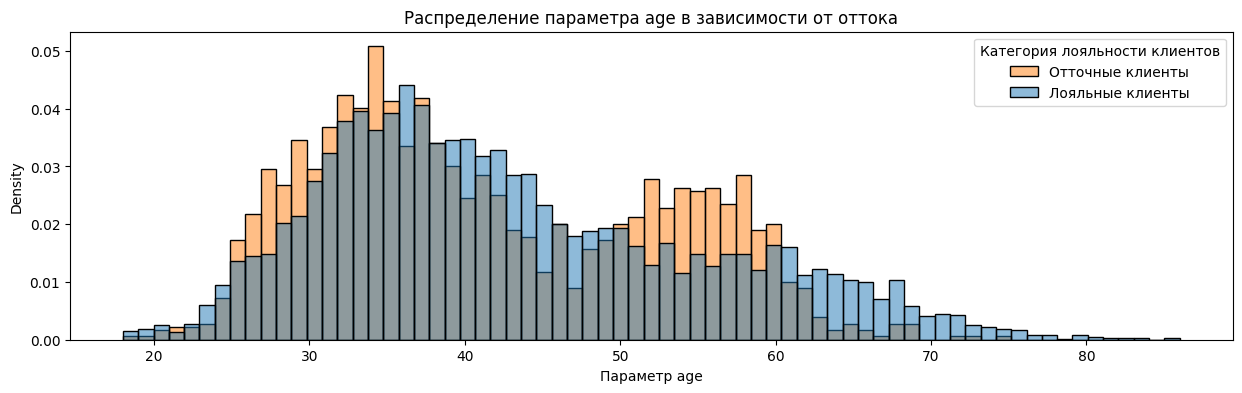

In [33]:
continuous_parameter(clients,
                     'age',
                     int(clients['age'].max()-clients['age'].min()+1))

In [34]:
churn_age_25_35 = round(clients
                        .loc[(clients['age'] >= 25)
                             & (clients['age'] <= 35)]['churn']
                        .mean()*100, 1)
churn_age_50_60 = round(clients
                        .loc[(clients['age'] >= 50)
                             & (clients['age'] <= 60)]['churn']
                        .mean()*100, 1)

print(f'Отток среди клиентов в возрасте 25-30 лет - {churn_age_25_35}%,\
\nОтток среди клиентов в возрасте 50-60 лет - {churn_age_50_60}%.')

Отток среди клиентов в возрасте 25-30 лет - 21.9%,
Отток среди клиентов в возрасте 50-60 лет - 26.5%.


*Комментарий.* На графике явно выделяются два возрастных интервала, для которых больше отточных клиентов чем лояльных:
- 25-35 лет (отток 21,9%);
- 50-60 лет (отток 26,5%).

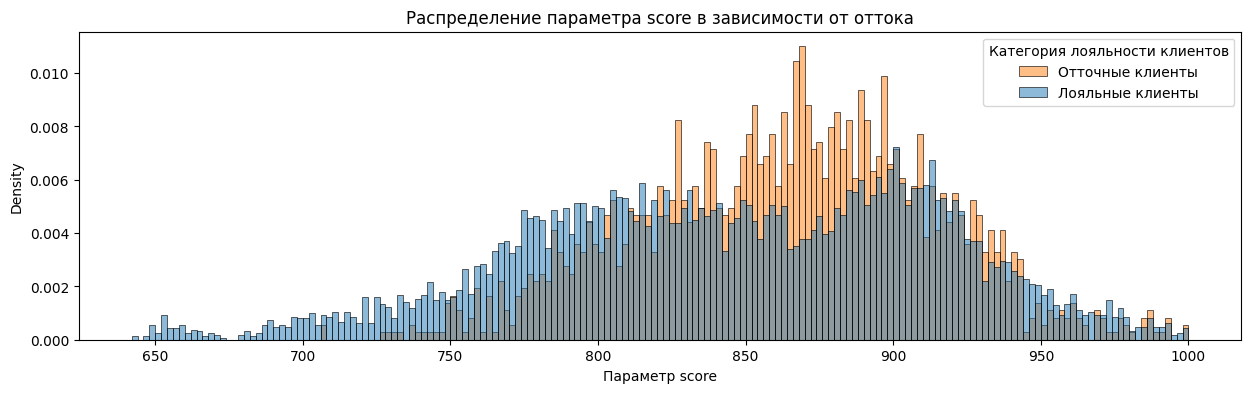

In [35]:
continuous_parameter(clients,
                     'score',
                     int((clients['score'].max()-clients['score'].min())/2))

In [36]:
churn_score_825_900 = round(clients
                            .loc[(clients['score'] >= 825)
                                 & (clients['score'] <= 900)]['churn']
                            .mean()*100, 1)
churn_score_925_975 = round(clients
                            .loc[(clients['score'] >= 925)
                                 & (clients['score'] <= 975)]['churn']
                            .mean()*100, 1)

print(f'Отток среди клиентов с кредитным скорингом 825-900 - {churn_score_825_900}%,\
\nОтток среди клиентов с кредитным скорингом 925-975 - {churn_score_925_975}%.')

Отток среди клиентов с кредитным скорингом 825-900 - 25.1%,
Отток среди клиентов с кредитным скорингом 925-975 - 17.0%.


*Комментарий.* На графике явно выделяются два интервала баллов кредитного скоринга, для которых больше отточных клиентов чем лояльных:
- 825-900 баллов (отток 25,1%);
- 925-975 баллов (отток 17%).

Для анализа распределения клиентов по est_salary используем common_clients, где представлены рядовые клиенты (состоятельные отсеяны).

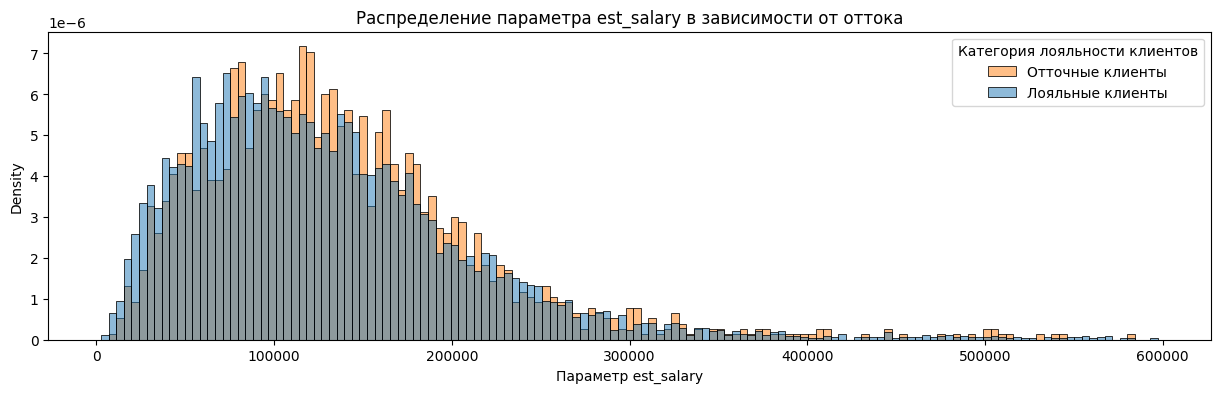

In [37]:
continuous_parameter(common_clients,
                     'est_salary',
                     int((clients['est_salary'].max()-clients['est_salary'].min())/10000))

In [38]:
churn_salary_75_210 = round(clients
                            .loc[(clients['est_salary'] >= 75*10**3)
                                 & (clients['est_salary'] <= 210*10**3)]['churn']
                            .mean()*100, 1)

print(f'Отток среди клиентов с зарплатой 75-210 тыс. - {churn_salary_75_210}%.')

Отток среди клиентов с зарплатой 75-210 тыс. - 20.0%.


*Комментарий.* На графике можно выделить интервал ожиадаемого уровня зарплаты 75-210 тыс., для которого больше отточных клиентов чем лояльных (отток 20%).

Для анализа распределения клиентов по balance используем common_balance_clients на основе исходного датафрейма df_initial (т.к. большое количество пропусков заполнили одним (медианным) значением, которое позволит распределить клиентов по группам, но не покажет реальную картину распределения данного параметра).

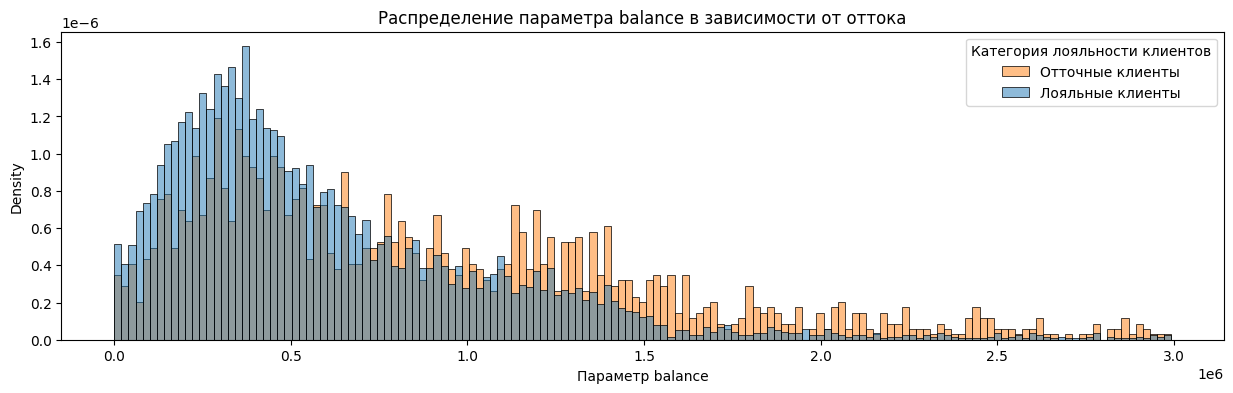

In [39]:
continuous_parameter(common_balance_clients,
                     'balance',
                     int((common_balance_clients['balance'].max()-common_balance_clients['balance'].min())/20000))

In [40]:
churn_balance_750 = round(clients
                            .loc[clients['est_salary'] >= 750*10**3]['churn']
                            .mean()*100, 1)

print(f'Отток среди клиентов с балансом на счете более 750 тыс. - {churn_balance_750}%.')

Отток среди клиентов с балансом на счете более 750 тыс. - 13.9%.


*Комментарий.* По графику можно сказать, что отточные клиенты начинают преобладать над лояльными с суммой на счету более 750 тыс. (отток 13,9%).

#### Дискретные/категориальные признаки

Далее предстоит решать однотипные задачи по определению уровня оттока по дискретным/категориальным параметрам. Определим функцию, которой на вход будут подаваться: датафрейм, параметр, ось графика, - discrete_parameter(data, parameter, ax=None). А на выходе получим столбчатую диаграмму для каждого параметра. Для этого:
- создадим pivot_table с количеством клиентов попавших в отток и общим количеством клиентов, разделенных по соответствующему параметру;
- добавим колонку с информацией о доле отточных клиентов - pivot_table['churn_rate'];
- построим столбчатую диаграмму для указанного параметра по доле отточных клиентов;
- добавим на диаграмму линию, показывающую средний по банку отток клиентов.

In [41]:
def discrete_parameter(data, parameter, ax=None):
    #Если ax не передан, используем текущие оси.
    if ax is None:
        ax = plt.gca()
    
    #Создадим pivot-таблицу.
    pivot_table = (
        pd.pivot_table(
            data=data,
            index=parameter,
            values='churn',
            aggfunc=['sum', 'count']
        )
        .rename(columns={'sum': 'total_churn', 'count': 'total_clients', 'churn': ''})
    )
    
    #Добавим столбец с долей оттока.
    pivot_table['churn_rate'] = pivot_table['total_churn'] * 100 / pivot_table['total_clients']
    
    #Построим столбчатую диагрмму на указанных осях.
    pivot_table['churn_rate'].plot(
        kind='bar',
        ax=ax,
        label='Средний отток по параметру'
    )
    
    #Добавим горизонтальную линию среднего оттока.
    ax.axhline(
        y=round(data['churn'].mean() * 100, 2),
        color='r',
        linestyle='--',
        label=f'Средний отток по банку - {round(data["churn"].mean() * 100, 2)}%'
    )
    
    #Оформим график.
    ax.legend()
    ax.set_title(f'Отток клиентов по параметру {parameter}')
    ax.set_ylabel('Отток, %')
    ax.set_xlabel(f'Параметр {parameter}')

Автоматизируем построение столбчатых диаграмм для дискретных/категориальных параметров:
- используем ранее созданный список соотвествующих столбцов discrete_col_names,
- расположим графики, построенные функцией discrete_parameter по очереди в 2 колонки (используем plt.subplots(), и цикл со счетчиком).

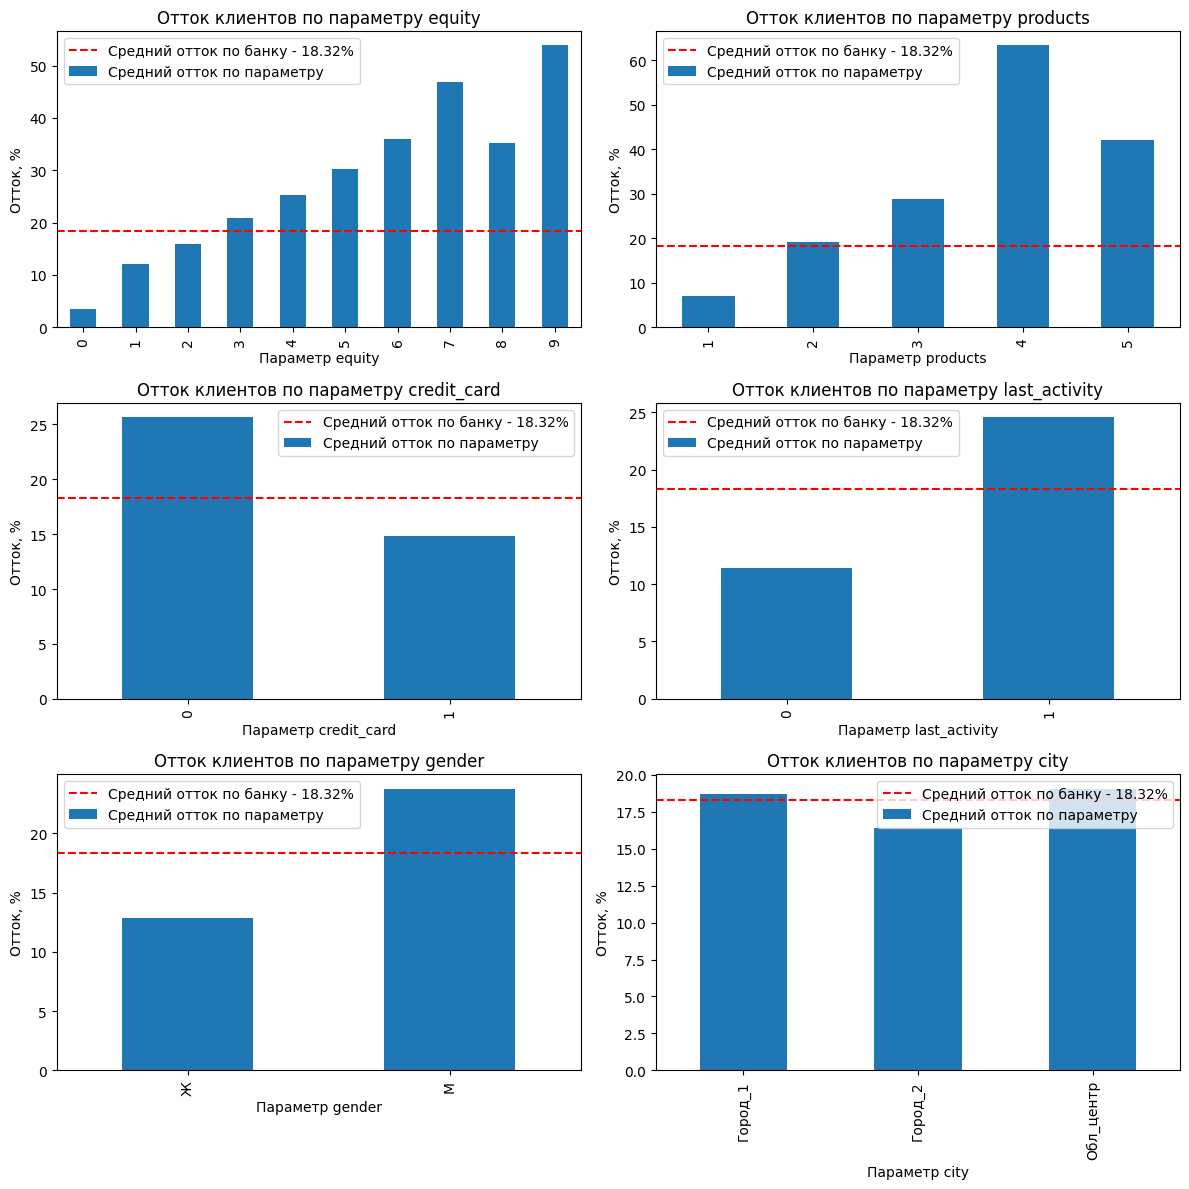

In [42]:
#Вычислим количество строк с округлением вверх, исключая 'churn'.
nrows = int(np.ceil(sum(1 for col in discrete_col_names if col != 'churn') / 2))

#Создадим фигуру и подграфики.
fig, axes = plt.subplots(nrows, 2, figsize=(12, 4 * nrows))

#Если количество графиков нечётное, скроем последний пустой подграфик.
if sum(1 for col in discrete_col_names if col != 'churn') % 2 != 0:
    axes[-1, -1].set_visible(False)

#Счетчик для корректного перебора.
count = 0

#Переберем колонки.
for i, column in enumerate(discrete_col_names):
    if column == 'churn':
        continue  #Пропустим 'churn'.
    
    #Определим позицию подграфика.
    row = count // 2
    col = count % 2
    count += 1
    
    #Получим текущий подграфик.
    if nrows > 1:
        ax = axes[row, col]
    else:
        ax = axes[col]  #Для случая с одной строкой.
    
    #Вызовем функцию discrete_parameter.
    discrete_parameter(clients, column, ax=ax)

plt.tight_layout()
plt.show()

*Комментарий.*
**Средний отток по банку составил 18,3%.**

Среди всех признаков есть значения, для которых отток выше среднебанковского:

1. Признак equity (количество баллов собственности):
   - Отток для значений от 3 и выше.
   - Больше всего к оттоку склонны клиенты, для которых значение параметра равно 7 и 9 (отток 45-50%), затем можно выделить клиентов со значениями 6 и 8 (отток 35%), и в третью группу - 3-5 (до 30%).
   - (Минимальный отток среди тех, у кого нет собственности (значение параметра равно 0).)<br>
<br>
2. Признак products (используемые продукты банка):
   - Отток клиентов, для которых значение параметра равно 2, находится примерно на уровне (нзначительно выше) среднебанковского.
   - Наибольший отток наблюдается для группы 4 - 60%. Для группы 5 отток составляет порядка 40%, для 3 - 30%.
   - (Минимальный отток среди клиентов, которые пользуются 1 продуктом.)<br>
<br>
3. Признак credit_card (наличие кредитной карты):
   - Отток для клиентов, не имеющих кредитные карты около 25%.
   - (Среди клиентов, имеющих кредитные карты отток значительно ниже среднебанковского и составляет порядка 14%.)<br>
<br>
4. Признак last_activity (активность в последние 60 дней):
   - Среди активных клиентов отточных - 25%.
   - (Среди клиентов, не совершавших действия в последние 60 дней, в отток попали около 12%.)<br>
<br>   
5. Признак clients_gender (пол):
   - Мужчины более склонны к оттоку - около 23%.
   - (Отток среди женщин составл порядка 13%.)<br>
<br>   
6. Признак clients_city (наличие кредитной карты):
   - Отток среди клиентов из областного центра и Города 2 несильно, но выше среднебанковского. 
   - (Отток среди клиентов Города 1 - около 16%.)

#### Вывод

Вывод оформим в виде таблицы.

In [43]:
data = {
    'Признак': [
        'Среднебанковский отток',
        'age', 
        'score', 
        'est_salary', 
        'balance', 
        'equity', 
        'products', 
        'credit_card', 
        'last_activity', 
        'clients_gender', 
        'clients_city'
    ],
    'Характерные отточные интервалы и значения': [
        '18.3%',
        '25-35 лет (отток 21,9%); 50-60 лет (отток 26,5%)',
        '825-900 баллов (отток 25,1%); 925-975 баллов (отток 17%)',
        '75-210 тыс. (отток 20%)',
        'от 750 тыс. (отток 13,9%)',
        '7,9 (отток 45-50%); 6,8 (отток 40%); 3 (отток 30%)',
        '4 (отток 60%); 5 (отток 40%); 3 (отток 30%)',
        '0 (не имеют кредитные карты, отток 25%)',
        '1 (активные, отток 25%)',
        'М (мужчины, отток 23%)',
        'Областной центр, Город 2 (отток 18-19%)'
    ]
}


conclusion_eda2 = pd.DataFrame(data)

#Отформатируем таблицу: выделим названия столбцов, добавим заголовок таблицы.
conclusion_eda2 = conclusion_eda2.style\
        .set_table_styles([
        {'selector': 'th', 'props': [('font-weight', 'bold')]},
        {'selector': 'caption', 'props': [
            ('font-size', '12pt'),
            ('color', 'black'),
            ('text-align', 'center')
        ]}
    ])\
    .set_caption('На основе распределения признаков в разрезе оттока\
    были выделены интервалы и значения признаков,\
    в которых клиенты демонстрируют наибольший отток.')  

#Настроим отображение.
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.width', 200)

conclusion_eda2

,Признак,Характерные отточные интервалы и значения
0,Среднебанковский отток,18.3%
1,age,"25-35 лет (отток 21,9%); 50-60 лет (отток 26,5%)"
2,score,"825-900 баллов (отток 25,1%); 925-975 баллов (отток 17%)"
3,est_salary,75-210 тыс. (отток 20%)
4,balance,"от 750 тыс. (отток 13,9%)"
5,equity,"7,9 (отток 45-50%); 6,8 (отток 40%); 3 (отток 30%)"
6,products,4 (отток 60%); 5 (отток 40%); 3 (отток 30%)
7,credit_card,"0 (не имеют кредитные карты, отток 25%)"
8,last_activity,"1 (активные, отток 25%)"
9,clients_gender,"М (мужчины, отток 23%)"


### Корреляционный анализ

Посмотрим, насколько связаны между собой параметры.
Рассчитаем корреляцию Пирсона. Выведем результат в виде графика корреляции в целом между параметрами и в частности (для удобства и наглядности) для оттока (churn).

Оценку результатов проведем по шкале Чеддока: 
- 0,1 и меньше — очень слабая связь; 
- от 0,1 до 0,3 — слабая связь; 
- от 0,3 до 0,5 — умеренная связь; 
- от 0,5 до 0,7 — заметная связь; 
- от 0,7 до 0,9 — высокая связь; 
- 0,9 и больше — очень высокая связь.

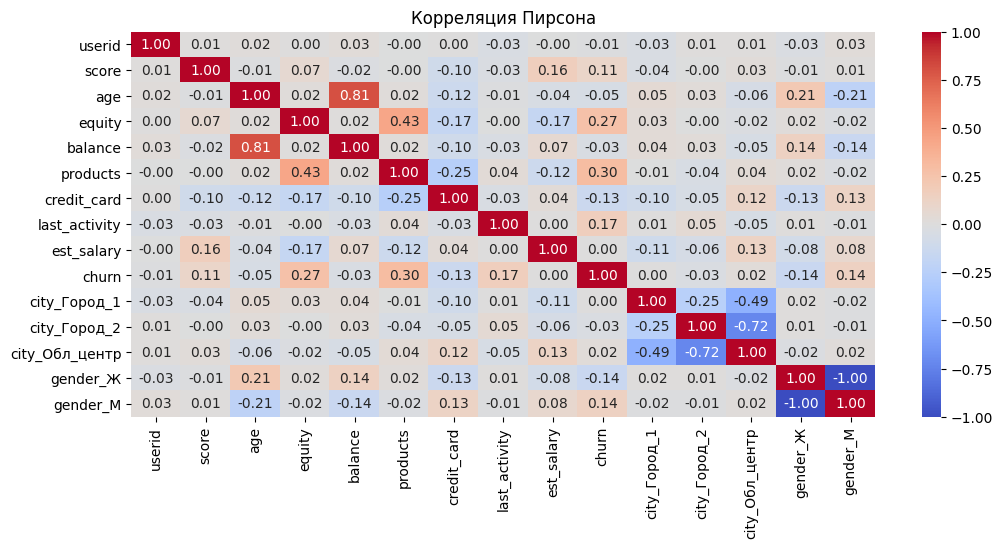

In [44]:
plt.figure(figsize=(12,5))
sns.heatmap(clients_coded.corr(), 
            annot=True, fmt=".2f", 
            cmap='coolwarm', center=0)

plt.title('Корреляция Пирсона');

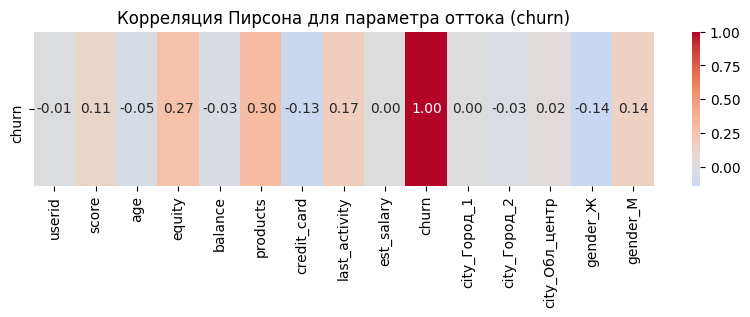

In [45]:
plt.figure(figsize=(10, 2))
sns.heatmap(clients_coded.corr().loc[['churn']], annot=True, fmt=".2f", cmap='coolwarm', center=0)

plt.title('Корреляция Пирсона для параметра оттока (churn)');

#### Вывод

В общем:
- Наблюдается высокая отрицательная корреляция между городами Рыбинск и Ярославль (-0,72), умеренная между Ростовом и Ярославлем (-0,49). Между Рыбинском и Ростовом слабая связь (-0,25). Такая связь объясняется населением этих городов.
- Высокая связь между такими параметрами как age и balance обусловлена тем, что заполнение пропусков в balance проводили на основе возрастных категорий.
- Умеренная корреляция (0,43) между количеством баллов собственности (equity) и количеством используемых продуктов (products). Логично с точки зрения, что собственность может быть вязата в кредит, застрахована. Слабая связь (-0,25) также существует между количеством баллов собственности (products) и наличием кредитной карты (credit_card).
- Слабая корреляция (0,21) наблюдается между возрастом (age) и полом (gender) клиентов.

В частности для оттока (churn):
- Параметр products имеет положительную умеренную корреляцию с churn (0.30), что может указывать на то, что клиенты, использующие больше продуктов, имеют чуть более высокую вероятность оттока.
- credit_card показывает слабую положительную корреляцию (0.17), что может свидетельствовать о том, что наличие кредитной карты немного связано с вероятностью оттока.
- last_activity имеет слабую отрицательную корреляцию (-0.13), что может означать, что активная деятельность клиента снижает вероятность оттока.
- Большинство параметров, таких как userid, score, age, equity, balance, est_salary, а также городские и гендерные индикаторы (city_Город_1, city_Город_2, city_Обл_центр, gender_Ж, gender_М), не показывают значимой корреляции с churn. Это может указывать на то, что эти факторы не оказывают существенного влияния на вероятность оттока клиентов.

### Проверка статистических гипотез

Проверим несколько гипотез отноительно представленных данных. При выборе теста предпочтение по возможности будем отдавать t-тесту. Проверка применимости t-теста:
- проверим данные на нормальность распределения - проведем тест Шапиро-Уилка;
- проверим равенство дисперсий;
- учтем ЦПТ, что для объема выборки обычно более 30, распределение выборочных средних приближается к нормальному, даже при ненормальном распределении исходных данных.

Oпределим функцию: 
- для проведения теста Шапиро_Уилка с интерпретацией результатов - check_normality;
- для проведения теста Левина с интерпретацией результатов - levenes_test;
- для проверки применимости ЦПТ - clt_applicability.

In [46]:
#Функция для проверки нормальности распределения.
def check_normality(sample, parameter, alpha=0.05):
    stat, p_value = st.shapiro(sample)
    
    #Результаты.
    print(f'\n--- Нормальность {parameter} ---')
    print(f'Статистика теста: {stat:.4f}')
    print(f'P-значение: {p_value:.4f}')
    
    #Интерпретация результатов.
    if p_value > alpha:
        print('\n=> Данные распределены нормально (гипотеза принимается).\
        \nДля проверки равенства дисперсий проведем F-тест.')
    else:
        print('\n=> Данные НЕ распределены нормально (гипотеза отвергается).\
        \nДля проверки равенства дисперсий проведем тест Левина.')

In [47]:
def levenes_test(sample1, sample2, alpha=0.05):
    stat, p_value = levene(sample1, sample2)

    #Результаты.
    print("Результаты теста Левина:")
    print(f"Статистика теста: {stat:.4f}")
    print(f"P-значение: {p_value:.4f}")

    #Интерпретация результатов.
    if p_value > alpha:
        print('\n=> Дисперсии равны (гипотеза принимается).\
        \nУстановим параметр equal_var=True.')
    else:
        print('\n=> Дисперсии НЕ равны (гипотеза отвергается).\
        \nНеобходимо задать параметр equal_var=False.')

In [48]:
def clt_applicability(sample1, sample2):
    #Размеры выборок.
    n1 = len(sample1)
    n2 = len(sample2)
    
    #Проверяка условия применимости ЦПТ.
    if (n1 >= 30) and (n2 >= 30):
        clt_applicable = True
        conclusion = 'ЦПТ применима: обе выборки достаточно большие (n1 >= 30 и n2 >= 30)'
    elif (n1 < 30) and (n2 < 30):
        clt_applicable = False
        conclusion = 'ЦПТ неприменима: обе выборки слишком маленькие (n1 < 30 и n2 < 30)'
    else:
        clt_applicable = False
        conclusion = 'ЦПТ частично применима: только одна выборка достаточно большая'
    
    #Интерпретация результата.
    print(f"Размер первой выборки: {n1}")
    print(f"Размер второй выборки: {n2}")
    print(f"\nВывод: {conclusion}")

#### Гипотеза 1

*Гипотеза.*
<br>Доходы между ушедшими и оставшимися клиентами различаются.

*Нулевая гипотеза.*
<br>Средние доходы лояльных клиентов и клиентов, попавших в отток, равны.

*Альтернативная гипотеза.*
<br>Средние доходы лояльных клиентов и клиентов, попавших в отток, не равны.

*Проверка гипотезы.*
<br>Рассматривается равенство/неравенство средних двух независимых выборок. Для этого подходит двухсторонний t-тест для средних двух генеральных совокупностей (ttest_ind). Поскольку мы хотим проверить сам факт равенства или отклонения, нам не важно в какую сторону отклонится среднее, зададим alternative='two-sided' Проверим применимость теста для представленных данных.

Определим данные, для которых необходимо проверить гипотезу. Используем датасет, очищенный от сильных выбросов, - common_clients.

In [49]:
est_salary_0 = common_clients.query('churn == 0')['est_salary']
est_salary_1 = common_clients.query('churn != 0')['est_salary']

Проведем тест Шапиро-Уилка, используем функцию check_normality.

In [50]:
check_normality(est_salary_0, 'уровня дохода лояльных клиентов')
check_normality(est_salary_1,  'уровня дохода отточных клиентов')


--- Нормальность уровня дохода лояльных клиентов ---
Статистика теста: 0.9034
P-значение: 0.0000

=> Данные НЕ распределены нормально (гипотеза отвергается).        
Для проверки равенства дисперсий проведем тест Левина.

--- Нормальность уровня дохода отточных клиентов ---
Статистика теста: 0.9026
P-значение: 0.0000

=> Данные НЕ распределены нормально (гипотеза отвергается).        
Для проверки равенства дисперсий проведем тест Левина.


D:\Analysis\Ana_conda\envs\practicum\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Проведем тест Левина, используем функцию levenes_test.

In [51]:
levenes_test(est_salary_0, est_salary_1)

Результаты теста Левина:
Статистика теста: 2.0658
P-значение: 0.1507

=> Дисперсии равны (гипотеза принимается).        
Установим параметр equal_var=True.


Определим применимость ЦПТ, используем функцию clt_applicability.

In [52]:
clt_applicability(est_salary_0, est_salary_1)

Размер первой выборки: 7908
Размер второй выборки: 1791

Вывод: ЦПТ применима: обе выборки достаточно большие (n1 >= 30 и n2 >= 30)


*Комментарий.* Результаты проверки на применимость t-теста для исследуемых данных:
- В выборках данные распределены не нормально.
- Дисперссии выборок равны.
- Объем обеих выборок позволяет применить ЦПТ.

Вывод: t-тест применим.

Проведем двухсторонний t-тест для средних двух генеральных совокупностей (ttest_ind).

In [53]:
#Уровень значимости.
alpha=.05
        
hypothesis_1 = st.ttest_ind(est_salary_0, 
                            est_salary_1,
                            equal_var=True,
                            alternative='two-sided')

#Результат проверки.
print(f'p-значение: {hypothesis_1.pvalue:.5}')

#Интерпретация результата.
if hypothesis_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Средние доходы среди лояльных и отточных клиентов различаются.')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Средние доходы среди лояльных и отточных клиентов равны.')

p-значение: 0.00074426
Отвергаем нулевую гипотезу. Средние доходы среди лояльных и отточных клиентов различаются.


#### Гипотеза 2

*Гипотеза.*
<br>К оттоку склонны клиенты с большим балансом на счете.

*Нулевая гипотеза.*
<br>Средние балансы лояльных клиентов и клиентов, попавших в отток, равны.

*Альтернативная гипотеза.*
<br>Средний баланс на счете лояльных клиентов меньше среднего баланса клиентов, попавших в отток.

*Проверка гипотезы.*
<br>Рассматривается равенство/неравенство средних двух независимых выборок. Для этого подходит односторонний t-тест для средних двух генеральных совокупностей (ttest_ind). Поскольку мы хотим проверить смещение среднего второй выборки относительно первой в меньшую сторону, зададим alternative='less' Проверим применимость теста для представленных данных.

Определим данные, для которых необходимо проверить гипотезу. Используем датасет, очищенный от сильных выбросов, - common_balance_clients.

In [54]:
balance_0 = common_balance_clients.query('churn == 0')['balance']
balance_1 = common_balance_clients.query('churn != 0')['balance']

Проведем тест Шапиро-Уилка, используем функцию check_normality.

In [55]:
check_normality(balance_0, 'остатка на счете лояльных клиентов')
check_normality(balance_1,  'остатка на счете отточных клиентов')


--- Нормальность остатка на счете лояльных клиентов ---
Статистика теста: 0.8664
P-значение: 0.0000

=> Данные НЕ распределены нормально (гипотеза отвергается).        
Для проверки равенства дисперсий проведем тест Левина.

--- Нормальность остатка на счете отточных клиентов ---
Статистика теста: 0.9210
P-значение: 0.0000

=> Данные НЕ распределены нормально (гипотеза отвергается).        
Для проверки равенства дисперсий проведем тест Левина.


D:\Analysis\Ana_conda\envs\practicum\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Проведем тест Левина, используем функцию levenes_test.

In [56]:
levenes_test(balance_0, balance_1)

Результаты теста Левина:
Статистика теста: 248.5667
P-значение: 0.0000

=> Дисперсии НЕ равны (гипотеза отвергается).        
Необходимо задать параметр equal_var=False.


Определим применимость ЦПТ, используем функцию clt_applicability.

In [57]:
clt_applicability(balance_0, balance_1)

Размер первой выборки: 5780
Размер второй выборки: 1715

Вывод: ЦПТ применима: обе выборки достаточно большие (n1 >= 30 и n2 >= 30)


*Комментарий.* Результаты проверки на применимость t-теста для исследуемых данных:
- В выборках данные распределены не нормально.
- Дисперссии выборок не равны.
- Объем обеих выборок позволяет применить ЦПТ.

Вывод: t-тест применим при установлении параметра equal_var=False.

Проведем односторонний t-тест для средних двух генеральных совокупностей (ttest_ind).

In [58]:
#Уровень значимости.
alpha=.05
        
hypothesis_2 = st.ttest_ind(balance_0, 
                            balance_1,
                            equal_var=False,
                            alternative='less')

#Результат проверки.
print(f'p-значение: {hypothesis_2.pvalue:.5}')

#Интерпретация результата.
if hypothesis_2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Средний баланс на счете для лояльных клиентов меньше, чем у отточных.')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Средний баланс на счетах у лояльных и отточных клиентов равен.')

p-значение: 5.3582e-59
Отвергаем нулевую гипотезу. Средний баланс на счете для лояльных клиентов меньше, чем у отточных.


#### Вывод

Проведена проверка статистических гипотез:
1. *Гипотеза 1.* О равенстве доходов среди оставшихся и ушедших клиентов. <br>*Тест:* Двухсторонний t-тест для двух генеральных совокупностей. <br>*Результат:* Средний доход в исследуемых группах различается.
<br><br>
2. *Гипотеза 2.* О меньшем балансе на счетах лояльных клиентов по сравнению с отточными. <br>*Тест:* Односторонний t-тест для двух генеральных совокупностей. <br>*Результат:* Средний баланс на счетах лояльных клиентов меньше, чем у отточных.

### Вывод

#### Общий вывод

1. Исследовано распределение значений признаков:
- установлены выбросы в данных для est_salary и balance, для каждого случая созданы датасеты, содержащие информацию о рядовых клиентах;
- для параметра churn наблюдается большая разница (в 4 раза) в количестве данных, в дальнейшем для изучения данных в разрезе оттока применялась нормировка.
2. Исследовано распределение признаков в разрезе оттока. Определены интервалы и значения признаков, для которых отток выше среднебанковского, т.е. >18,3%.
3. Проведен корреляционный анализ. Установлена умеренная и слабая связь products с equity и credit_card, слабая корреляция между age и gender. Отток churn имеет умеренную связь с products, слабую с credit_card, last_activity. Большинство параметров, таких как userid, score, age, equity, balance, est_salary, а также городские и гендерные индикаторы (city_Город_1, city_Город_2, city_Обл_центр, gender_Ж, gender_М), не показывают значимой корреляции с churn. Это может указывать на то, что эти факторы не оказывают существенного влияния на вероятность оттока клиентов.
4. Проверены статистические гипотезы:
- *Гипотеза 1.* О равенстве доходов среди оставшихся и ушедших клиентов. <br>*Результат:* Средний доход в исследуемых группах различается.
- *Гипотеза 2.* О меньшем балансе на счетах лояльных клиентов по сравнению с отточными. <br>*Результат:* Средний баланс на счетах лояльных клиентов меньше, чем у отточных.

Результаты EDA позволяют определить взаимосвязи между признаками и оттоком.

#### Признаки, влияющие на отток

Выделим влияющие на отток признаки, на основе которых будем проводить сегментацию клиентов.
1) age: в интервалах 25-35 и 50-60 отток сильно превышает лояльность (соотвественно, 21,9% и 26,5%);<br>
2) est_salary: среднее значение признака среди ушедших отличается от оставшихся, отточный интервал значений 75-210 тыс. (20%);<br>
3) score: в интервале 825-900 отток (25,1%) сильно превышает лояльность;<br>
4) products: среди признаков имеет максимальный уровень оттока: 30-60% для значений 3-5;<br>
5) equity: высокий отток 30-50% для значений 3-9;<br>
6) credit_card: 0 - нет кредитной карты (25%);<br>
7) last_activity: 1 - активные (25%);<br>
8) clients_gender: М - мужчины (23%).

## Сегментация клиентов

Разделим отточных клиентов на сегменты с соблюдением условий:
- среднее значение оттока сегмента выше среднебанковского оттока;
- размер сегмента - от 500 человек;
- для сегментации использованы комбинации признаков, выделенных в предыдущем подпункте;
- количество сегментов 3-5.

Определим:
- Среднебанковский отток avg_bank_churn.
- Минимальный размер сегмента min_segment_size.
- Функцию segment_check, которая будет принимать на вход сегмент и выводить его и средний отток.

In [59]:
avg_bank_churn = round(clients['churn'].mean() * 100, 1)
min_segment_size = 500

In [60]:
def segment_check(segments, segment_names):

    for segment, name in zip(segments, segment_names):
        size = len(segment)
        segment_churn = round(segment['churn'].mean() * 100, 1)
        
        print(f'--- Результат проверки {name} на соответствие требованиям: ---')
        
        #Проверка размера сегмента.
        if size < min_segment_size:
            print(f'Размер сегмента — {size}. Требованиям НЕ соответствует.')
        else:
            print(f'Размер сегмента — {size}. Требованиям соответствует. '
                  f'Количество отточных клиентов — {int(round(size * segment_churn / 100, 0))}.')
        
        #Проверка оттока.
        if segment_churn < avg_bank_churn:
            diff = round(avg_bank_churn - segment_churn, 1)
            print(f'Средний отток по сегменту — {segment_churn}%. '
                  f'Ниже среднебанковского на {diff}%. '
                  'Требованиям НЕ соответствует.\n')
        else:
            diff = round(segment_churn - avg_bank_churn, 1)
            print(f'Средний отток по сегменту — {segment_churn}%. '
                  f'Выше среднебанковского на {diff}%. '
                  'Требованиям соответствует.\n')

Выделим сегменты, группируя клиентов по различным признакам.

In [61]:
#Сегмент 1: мужчины, от 3 ед. собственности, без кредитных карт.
segment1 = clients.loc[
    (clients['gender'] == 'М')
    & (clients['equity'] >= 3)
    & (clients['credit_card'] == 0)
]

#Сегмент 2: клиенты в возрасте 25-35 лет, с кредитным скорингом 825-900.
segment2 = clients.loc[
    (clients['age'] >= 25)
    & (clients['age'] <= 35)
    & (clients['score'] >= 825)
    & (clients['score'] <= 900)
]

#Сегмент 3: клиенты в возрасте 50-60 лет, активные пользователи.
segment3 = clients.loc[
    (clients['age'] >= 50)
    & (clients['age'] <= 60)
    & (clients['last_activity'] == 1)
]

#Сегмент 4: клиенты с зарплатой 75-210 тыс., использующие от 3 банковских продуктов.
segment4 = clients.loc[
    (clients['est_salary'] >= 75*10**3)
    & (clients['est_salary'] <= 210*10**3)
    &(clients['products'] >= 3)   
]

#Сегмент 5: клиенты с зарплатой 75-210 тыс., активные, от 3 ед. собственности.
segment5 = clients.loc[
    (clients['est_salary'] >= 75*10**3)
    & (clients['est_salary'] <= 210*10**3)
    & (clients['last_activity'] == 1)
    & (clients['equity'] >= 3)
]

Представим в виде списков сформированные сегменты и их названия.

In [62]:
segments = [segment1, 
            segment2, 
            segment3, 
            segment4, 
            segment5]

segments_list = ['Сегмент 1', 
                 'Сегмент 2', 
                 'Сегмент 3',  
                 'Сегмент 4',  
                 'Сегмент 5']

Проверим выделенные сегменты на соответствие требованиям, используем функцию segment_check.

In [63]:
segment_check(segments, segments_list)

--- Результат проверки Сегмент 1 на соответствие требованиям: ---
Размер сегмента — 889. Требованиям соответствует. Количество отточных клиентов — 419.
Средний отток по сегменту — 47.1%. Выше среднебанковского на 28.8%. Требованиям соответствует.

--- Результат проверки Сегмент 2 на соответствие требованиям: ---
Размер сегмента — 1252. Требованиям соответствует. Количество отточных клиентов — 371.
Средний отток по сегменту — 29.6%. Выше среднебанковского на 11.3%. Требованиям соответствует.

--- Результат проверки Сегмент 3 на соответствие требованиям: ---
Размер сегмента — 918. Требованиям соответствует. Количество отточных клиентов — 300.
Средний отток по сегменту — 32.7%. Выше среднебанковского на 14.4%. Требованиям соответствует.

--- Результат проверки Сегмент 4 на соответствие требованиям: ---
Размер сегмента — 884. Требованиям соответствует. Количество отточных клиентов — 385.
Средний отток по сегменту — 43.6%. Выше среднебанковского на 25.3%. Требованиям соответствует.

--- Рез

*Комментарий.* Клиенты разделены на 5 сегментов. Все 5 сегментов соотвествуют требованиям по количеству клиентов (от 884 до 1721) и уровню оттока (от 27,5% до 43,6%).

### Вывод

Были выделены следующие сегменты клиентов:<br>
1. Сегмент 1: мужчины, от 3 ед. собственности, без кредитных карт.
<br>Размер сегмента — 889. Требованиям соответствует. Количество отточных клиентов — 419.
<br>Средний отток по сегменту — 47.1%. Выше среднебанковского на 28.8%. Требованиям соответствует.<br>
<br>
2. Сегмент 2: клиенты в возрасте 25-35 лет, с кредитным скорингом 825-900.
<br>Размер сегмента — 1252. Требованиям соответствует. Количество отточных клиентов — 371.
<br>Средний отток по сегменту — 29.6%. Выше среднебанковского на 11.3%. Требованиям соответствует.<br>
<br>
3. Сегмент 3: клиенты в возрасте 50-60 лет, активные.
<br>Размер сегмента — 918. Требованиям соответствует. Количество отточных клиентов — 300.
<br>Средний отток по сегменту — 32.7%. Выше среднебанковского на 14.4%. Требованиям соответствует.<br>
<br>
4. Сегмент 4: клиенты с зарплатой 75-210 тыс., использующие от 3 банковских продуктов.
<br>Размер сегмента — 884. Требованиям соответствует. Количество отточных клиентов — 385.
<br>Средний отток по сегменту — 43.6%. Выше среднебанковского на 25.3%. Требованиям соответствует.<br>
<br>
5. Сегмент 5: клиенты с зарплатой 75-210 тыс., активные, от 3 ед. собственности.
<br>Размер сегмента — 1721. Требованиям соответствует. Количество отточных клиентов — 707.
<br>Средний отток по сегменту — 41.1%. Выше среднебанковского на 22.8%. Требованиям соответствует.

## Приоритизация сегментов

В качестве критерия для приоритизации будем использовать количество отточных клиентов в сегменте. Или другими словами, количество клиентов, на которых будут направлены мероприятия по удержанию.
- Создадим датафрейм с данными по сегментам, полученными на предыдущем шаге.
- Категоризируем сегменты по приоритету: высокий, средний, низкий.

In [64]:
#Исходные данные по сегментам
segmented_data = {
    'сегмент': [
        'Сегмент 1',
        'Сегмент 2',
        'Сегмент 3',
        'Сегмент 4',
        'Сегмент 5'
    ],
    'краткая_справка': ['мужчины, ≥3 ед. собственности, без кредитных карт',
                       '25–35 лет, скоринг 825–900',
                       '50–60 лет, активные',
                       'зарплата 75–210 тыс., ≥3 банковских продуктов',
                       'зарплата 75–210 тыс., активные, ≥3 ед. собственности'],
    'размер': [889, 1252, 918, 884, 1721],
    'отток_%': [47.1, 29.6, 32.7, 43.6, 41.1],
    'отточные_клиенты': [419, 371, 300, 385, 707],
    'выше_среднебанковского_на%': [28.8, 11.3, 14.4, 25.3, 22.8]
}

segmented_clients = pd.DataFrame(segmented_data)
segmented_clients

,сегмент,краткая_справка,размер,отток_%,отточные_клиенты,выше_среднебанковского_на%
0,Сегмент 1,"мужчины, ≥3 ед. собственности, без кредитных карт",889,47.1,419,28.8
1,Сегмент 2,"25–35 лет, скоринг 825–900",1252,29.6,371,11.3
2,Сегмент 3,"50–60 лет, активные",918,32.7,300,14.4
3,Сегмент 4,"зарплата 75–210 тыс., ≥3 банковских продуктов",884,43.6,385,25.3
4,Сегмент 5,"зарплата 75–210 тыс., активные, ≥3 ед. собственности",1721,41.1,707,22.8


Для категоризации и окончательной приоритизации сегментов объявим функцию priority, которая присвоит один из приоритетов (высокий, средний, низкий) каждому сегменту. За границы категорий примем значения 0,33 и 0,66 квантилей.

In [65]:
def priority(weight):
    if weight >= segmented_clients['отточные_клиенты'].quantile(0.67):
        return 'Высокий'
    elif weight >= segmented_clients['отточные_клиенты'].quantile(0.33):
        return 'Средний'
    else:
        return 'Низкий'

segmented_clients['приоритет'] = segmented_clients['отточные_клиенты'].apply(priority)
segmented_clients.sort_values(by='отточные_клиенты', ascending=False)

,сегмент,краткая_справка,размер,отток_%,отточные_клиенты,выше_среднебанковского_на%,приоритет
4,Сегмент 5,"зарплата 75–210 тыс., активные, ≥3 ед. собственности",1721,41.1,707,22.8,Высокий
0,Сегмент 1,"мужчины, ≥3 ед. собственности, без кредитных карт",889,47.1,419,28.8,Высокий
3,Сегмент 4,"зарплата 75–210 тыс., ≥3 банковских продуктов",884,43.6,385,25.3,Средний
1,Сегмент 2,"25–35 лет, скоринг 825–900",1252,29.6,371,11.3,Низкий
2,Сегмент 3,"50–60 лет, активные",918,32.7,300,14.4,Низкий


### Вывод

Приотизация сегментов была проведена по убыванию количества клиентов, которых можно удержать. Также каждому сегменту был привоен приоритет в зависимости от распределения отточных клиентов.

- Высокий приоритет присвоен сегменту 5 и сегменту 1.
- Средний - сегменту 4.
- Низкий - сегменту 2 и сегменту 3.

## Рекомендации

**ВЫСОКИЙ ПРИОРИТЕТ**

**Сегмент 5**:<br>
*Описание:* зарплата 75–210 тыс., активные, от 3 ед. собственности. Размер сегмента: 1721; отток: 41,1 %; превышение над среднебанковым: 22,8 %.<br>
Доход позволяет выбирать лучшие условия среди предложений на рынке. Количество собственности предполагает необходимость в комплексных финансовыъ решениях.

*Рекомендации:*
1. *Пакет собственника с сервисами для управления собственностью* (календарь платежей, интеграция с ГИС ЖКХ, скидки на страхование и услуги оценщиков). 
2. *Премиальное обслуживание* (персональный менеджер, приоритетная поддержка, эксклюзивные предложения для собственников).  
3. *Услуги компаний-партнеров на выгодных условиях* (компании по ремонту, страхованию, управлению недвижимостью и др.).

**Сегмент 1:** <br>
*Описание:* мужчины, от 3 ед. собственности, без кредитных карт. Рарзмер сегмента: 889; отток: 47,1 %; превышение над среднебанковым: 28,8 %.<br>
Наличие значительной собственности может означать финансовую независимость и высокую требовательность к условиям. Отсутствие кредитных карт — потенциальный «недоохват».

*Рекомендации:*
1. *Персональные кредитные продукты* (карта с льготным периодом, кэшбэком за недвижимость/ремонт, повышенными лимитами, рефинансирование по пониженной ставке при переводе всех платежей в банк).  
2. *Премиальное обслуживание* (персональный менеджер, приоритетная поддержка, эксклюзивные предложения для собственников).  
3. *Услуги компаний-партнеров на выгодных условиях* (компании по ремонту, страхованию, управлению недвижимостью и др.).

---
**СРЕДНИЙ ПРИОРИТЕТ**

**Сегмент 4**:<br>
*Описание:* зарплата 75–210 тыс., от 3 банковских продуктов. Размер сегмента: 884; отток: 43,6 %; превышение над среднебанковым: 25,3 %.<br>
Высокая занятость (доход) + множественность продуктов = риск «перегрузки» и неудовлетворённости; потенциальное ощущение «невыгодности» условий при большом объёме операций.

*Рекомендации:*
1. *Оптимизация используемых продуктов* (объединение услуг, снижение комиссий).  
2. *Привилегии* (бесплатное обслуживание, повышенные ставки по вкладам за каждый используемый продукт).  

---
**НИЗКИЙ ПРИОРИТЕТ**

**Сегмент 2**:<br>
*Описание:* 25–35 лет, скоринг 825–900. Размер сегмента: 1252; отток: 29,6 %; превышение над срднебанковым: 11,3 %.<br>
У молодых людей высокая кредитоспособность при этом они склонны искать лучшие предложения и условия.

*Рекомендации:*
1. *Цифровые продукты* (мобильный банк с ИИ-ассистентом, автоматизированные сбережения, инвестиции с низким входом).  
2. *Гибкие кредитные предложения с конкурентноспособной ставкой* (рефинансирование, кредиты на образование/переквалификацию).  
3. *Сообщества клиентов* (онлайн-клубы для обмена опытом, вебинары по финансовой грамотности).

**Сегмент 3:** <br>
*Описание:* 50–60 лет, активные. Размер сегмента: 918; отток: 32,7 %; превышение над среднебанковым: 14,4 %.<br>
Возрастная группа ценит надёжность и персонализацию. Активность предполагает заинтересованность в продуктах и вовлечённость. Возраст группы позволяет предположить, что у клиентов есть свободное время и возможности на "жизнь в удовольствие".

*Рекомендации:*
1. *Приоритетная поддержка* (выделенная линия, личные встречи с менеджером и экспертами, лекции по финансовой граммотности и безопасности).  
2. *Упрощённый интерфейс* (крупный шрифт, голосовое управление, четкая и понятная структура цифровых сервисов).  
3. *Бонусы за активность* (скидки на страхование, льготные курсы валют).

**ВАЖНОЕ НАБЛЮДЕНИЕ**
<br> ***Cуществует проблема в части обмена информацией о клиентах между Городом 2 и областным центром.***